In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sourcesep.models.nmf_variants import set_norm

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'


def gaussfn(x, mu, sig): return 1/(np.sqrt(2*np.pi)*sig) * \
    np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

a_col = gaussfn(np.arange(200), mu=20, sig=10)
b_col = gaussfn(np.arange(200), mu=80, sig=10)

a_col_ = np.concatenate([a_col, 2*a_col])
a_col_ = set_norm(a_col_.reshape(-1,1), axis=0, c=1)[0]

b_col_ = np.concatenate([b_col, 3*b_col])
b_col_ = set_norm(b_col_.reshape(-1,1), axis=0, c=1)[0]

A = np.concatenate([a_col_,b_col_], axis=1)

h_init = 0.5 * np.abs(np.random.rand(1, 100)) 
h_init = h_init.reshape(1,-1)
H = np.concatenate([1.0+h_init,1.0-h_init], axis=0)
X = A@H

print(f'A {A.shape}')
print(f'H {H.shape}')
print(f'X {X.shape}')

A (400, 2)
H (2, 100)
X (400, 100)


In [2]:
a_coeff = torch.tensor([1,0.5], requires_grad=True, dtype=torch.float32)
b_coeff = torch.tensor([1.,1.], requires_grad=True, dtype=torch.float32)
a_init = torch.tensor(np.abs(a_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)
b_init = torch.tensor(np.abs(b_col + np.random.randn(200)*0.01), requires_grad=True, dtype=torch.float32)

h_coeff = torch.tensor([1.,1.], requires_grad=True, dtype=torch.float32)
h_bias = torch.tensor([0.,0.], requires_grad=True, dtype=torch.float32)
h_init = torch.tensor(np.abs(np.random.rand(1, 100)) + 1.0, requires_grad=True, dtype=torch.float32) # this can be provided based on prior data

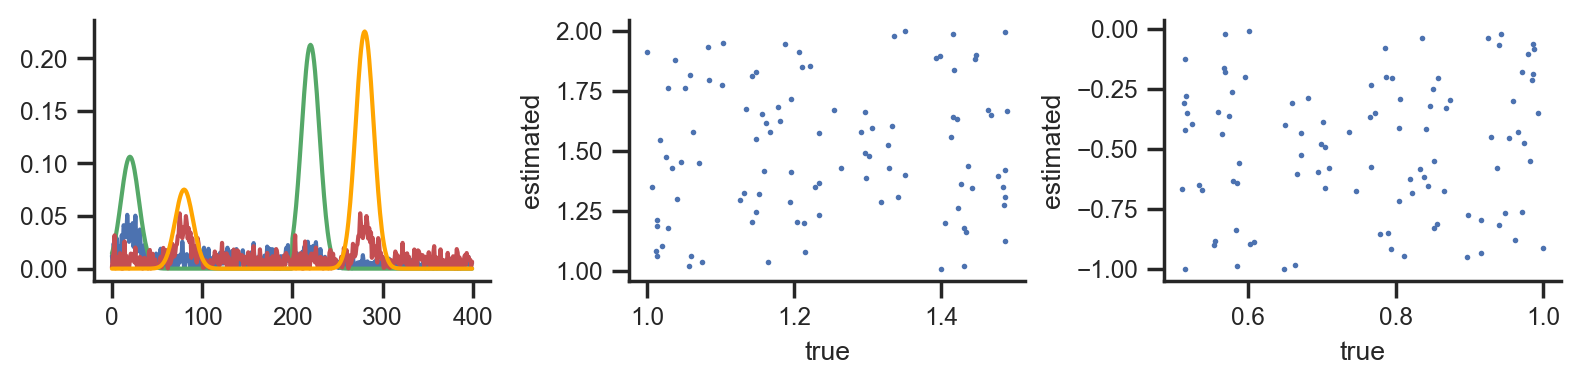

Loss: 13.643256187438965


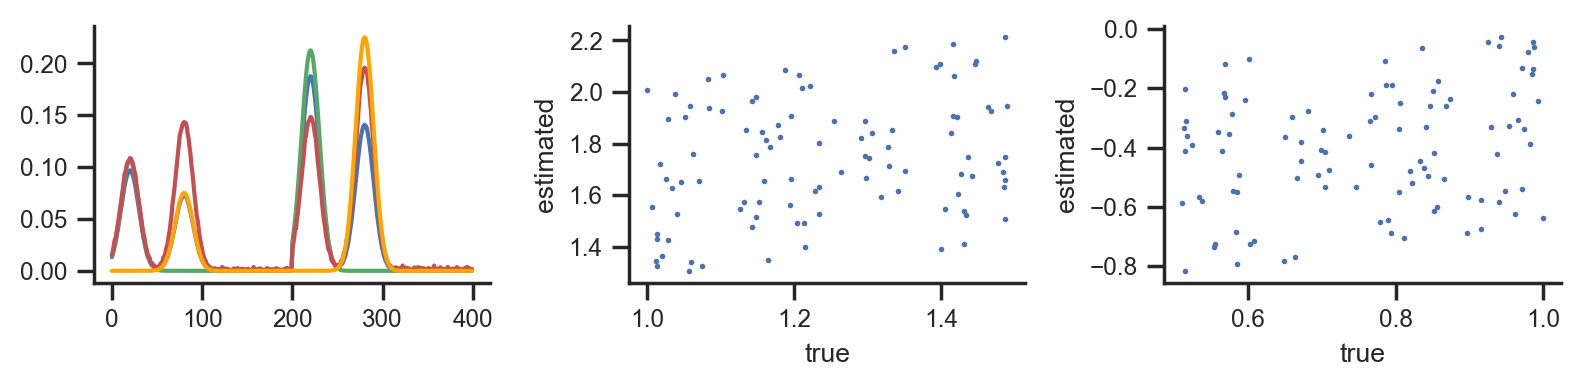

Loss: 2.2682909965515137


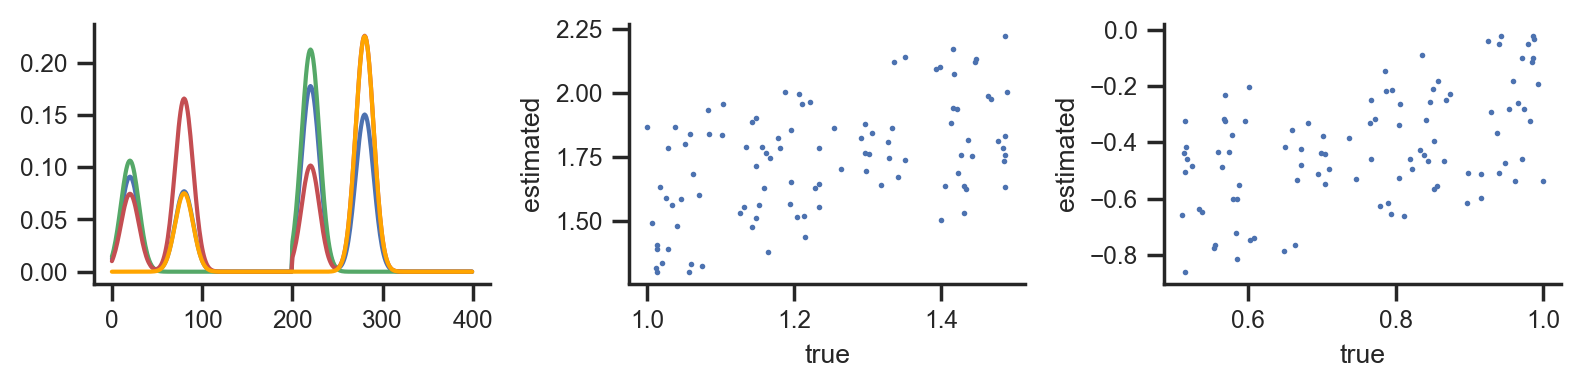

Loss: 2.0194966793060303


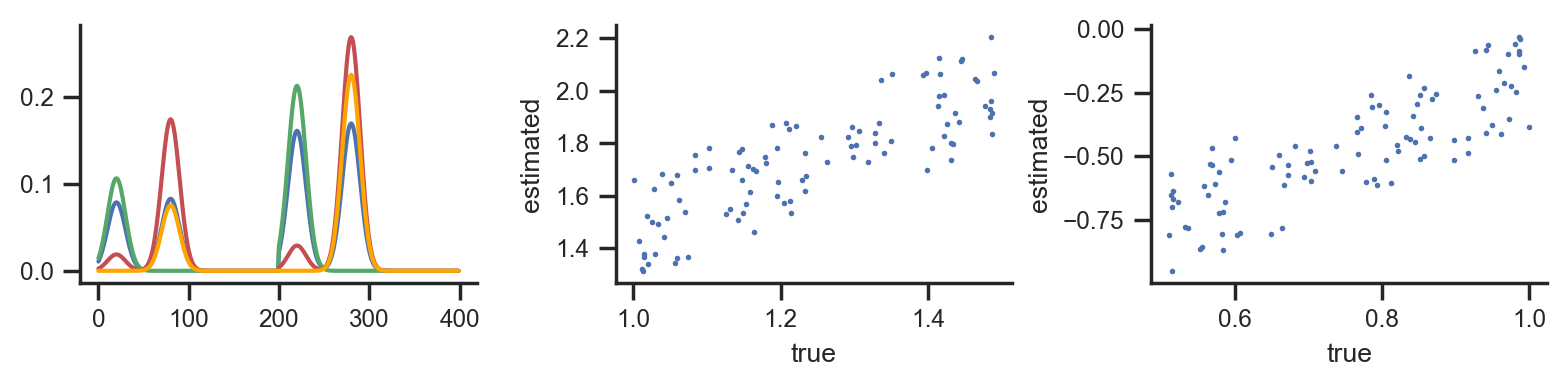

Loss: 1.3823742866516113


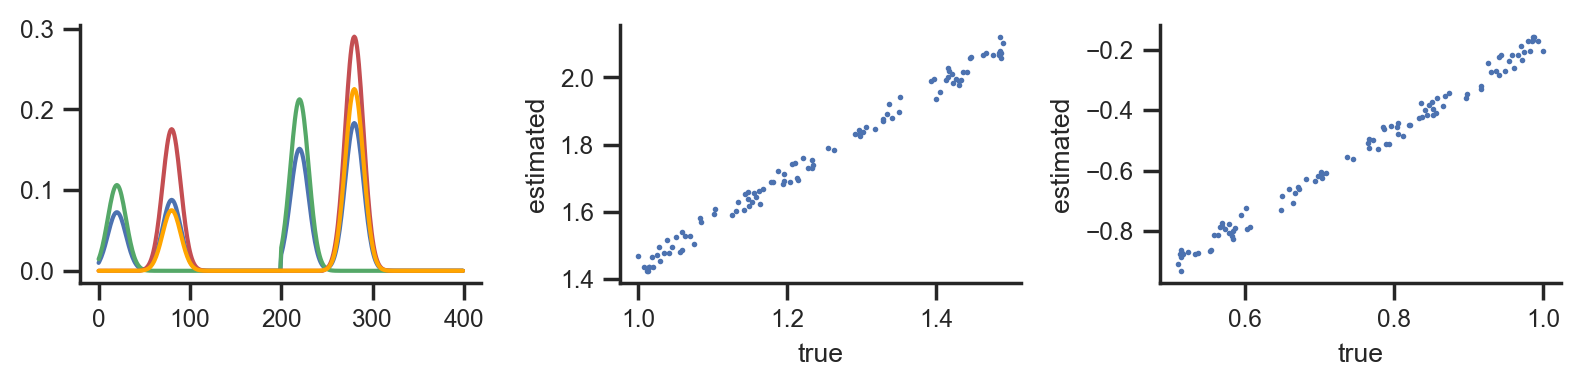

Loss: 0.6400802135467529


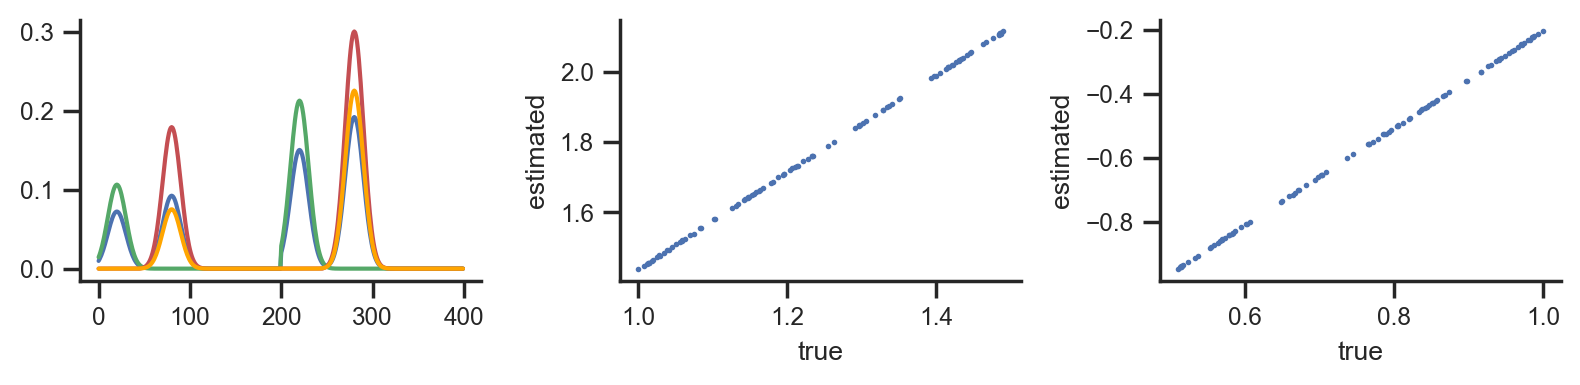

Loss: 0.5862367153167725


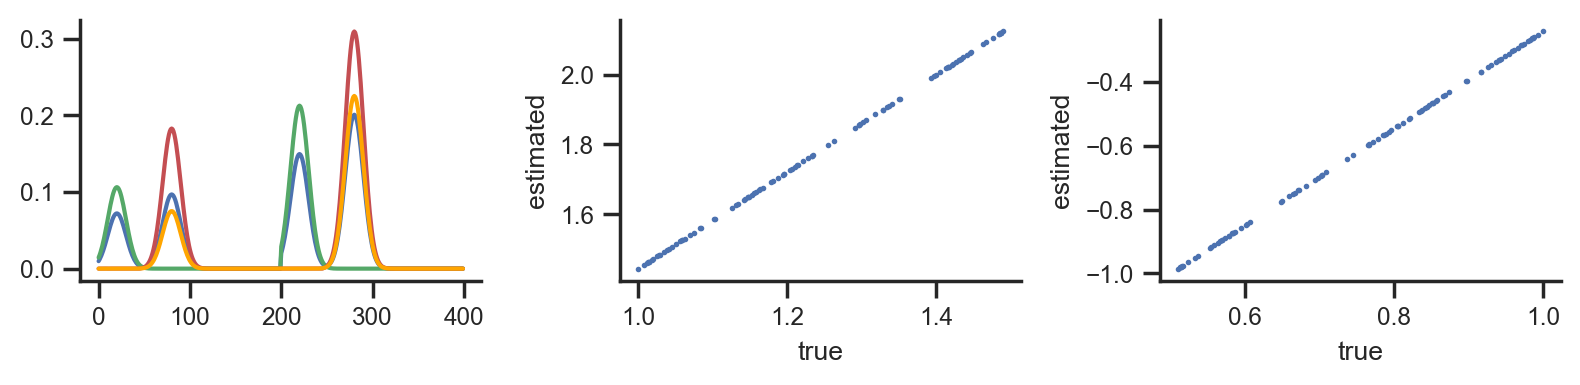

Loss: 0.5684475898742676


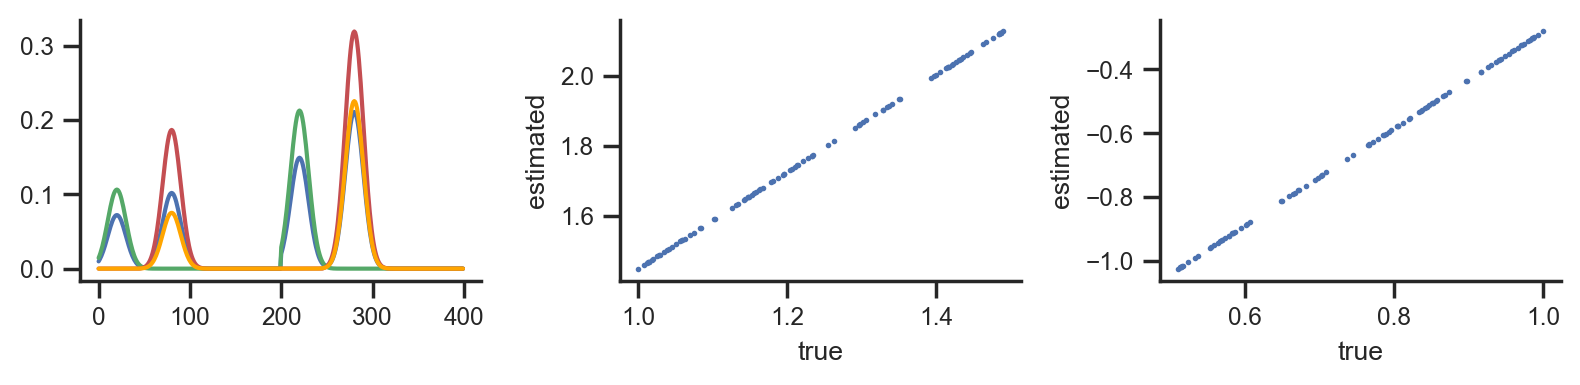

Loss: 0.5522439479827881


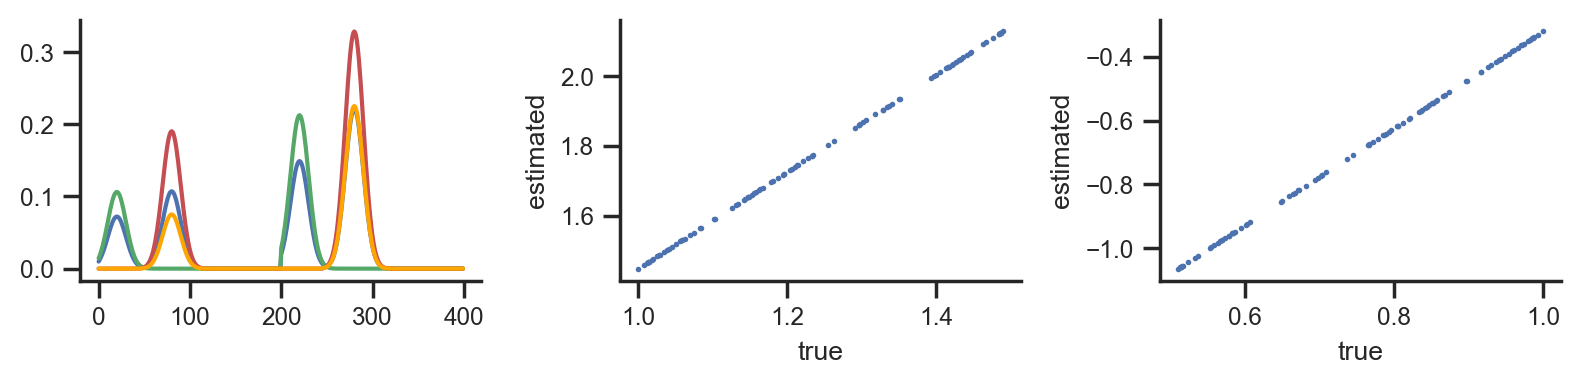

Loss: 0.5376369953155518


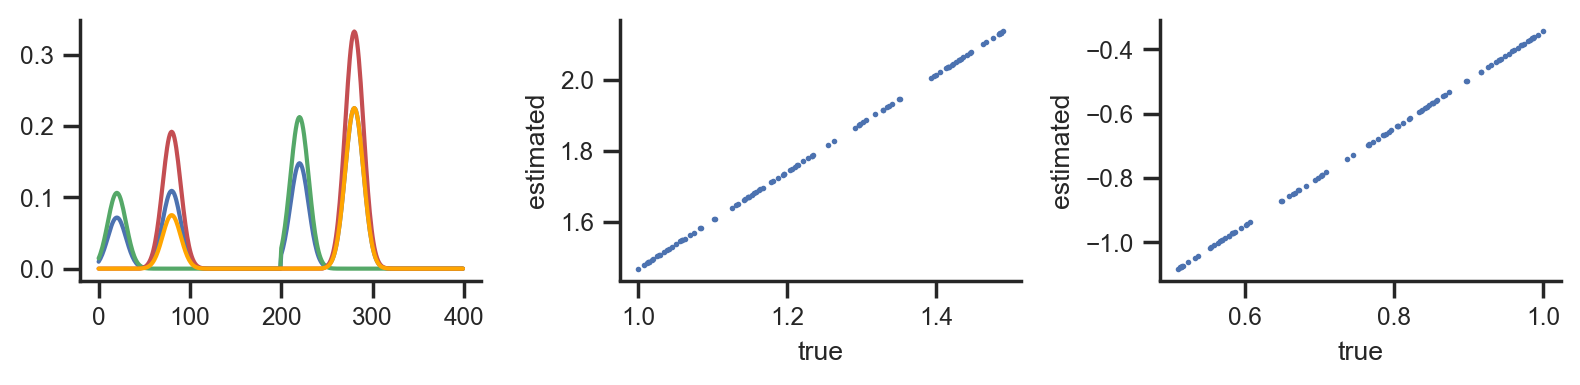

Loss: 0.5323911905288696


In [3]:


# Set learning rate
lr = .001

# post gradient step modifiers:
min_value = 1e-4
prox_plus = torch.nn.Threshold(0,min_value)
prox_softplus = torch.nn.Softplus()
def prox_norm(x):
    return x / torch.norm(x, p=2)

for i in range(20000):
    #Concatenate the two tensors to create the input matrix
    a_init_ = torch.cat((a_coeff[0]*a_init, a_coeff[1]*a_init), dim=0)
    b_init_ = torch.cat((b_coeff[0]*b_init, b_coeff[1]*b_init), dim=0)
    A_init = torch.stack((a_init_, b_init_), dim=0).T

    ha_init = h_coeff[0] * h_init + h_bias[0]
    hb_init = h_coeff[1] * (1-h_init) + h_bias[1]
    H_init = torch.cat((ha_init,hb_init), dim=0)

    X_ = torch.matmul(A_init, H_init)
    dmat = X_ - torch.as_tensor(X, dtype=torch.float32)
    loss = torch.linalg.matrix_norm(dmat, ord='fro')
    loss.backward(retain_graph=True) 

    with torch.no_grad():
        for p in [a_init, b_init, a_coeff, b_coeff, h_init, h_coeff, h_bias]:
            p -= lr * p.grad
            p.data = prox_plus(p)
            p.grad.zero_()

        for p in [a_init, b_init]:
            p.data = prox_norm(p)            

    if i%2000==0:
        f, ax = plt.subplots(1, 3, figsize=(8,2))
        ax[0].plot(a_init_.detach().numpy(), c='b')
        ax[0].plot(a_col_, c='g')
        ax[0].plot(b_init_.detach().numpy(), c='r')
        ax[0].plot(b_col_, c='orange')
        
        ax[1].scatter(H[0, :], H_init[0, :].detach().numpy(), s=1)
        ax[1].set(xlabel='true', ylabel='estimated')

        ax[2].scatter(H[1, :], H_init[1, :].detach().numpy(), s=1)
        ax[2].set(xlabel='true', ylabel='estimated')
        plt.tight_layout()
        plt.show()

        print(f'Loss: {loss.item()}')

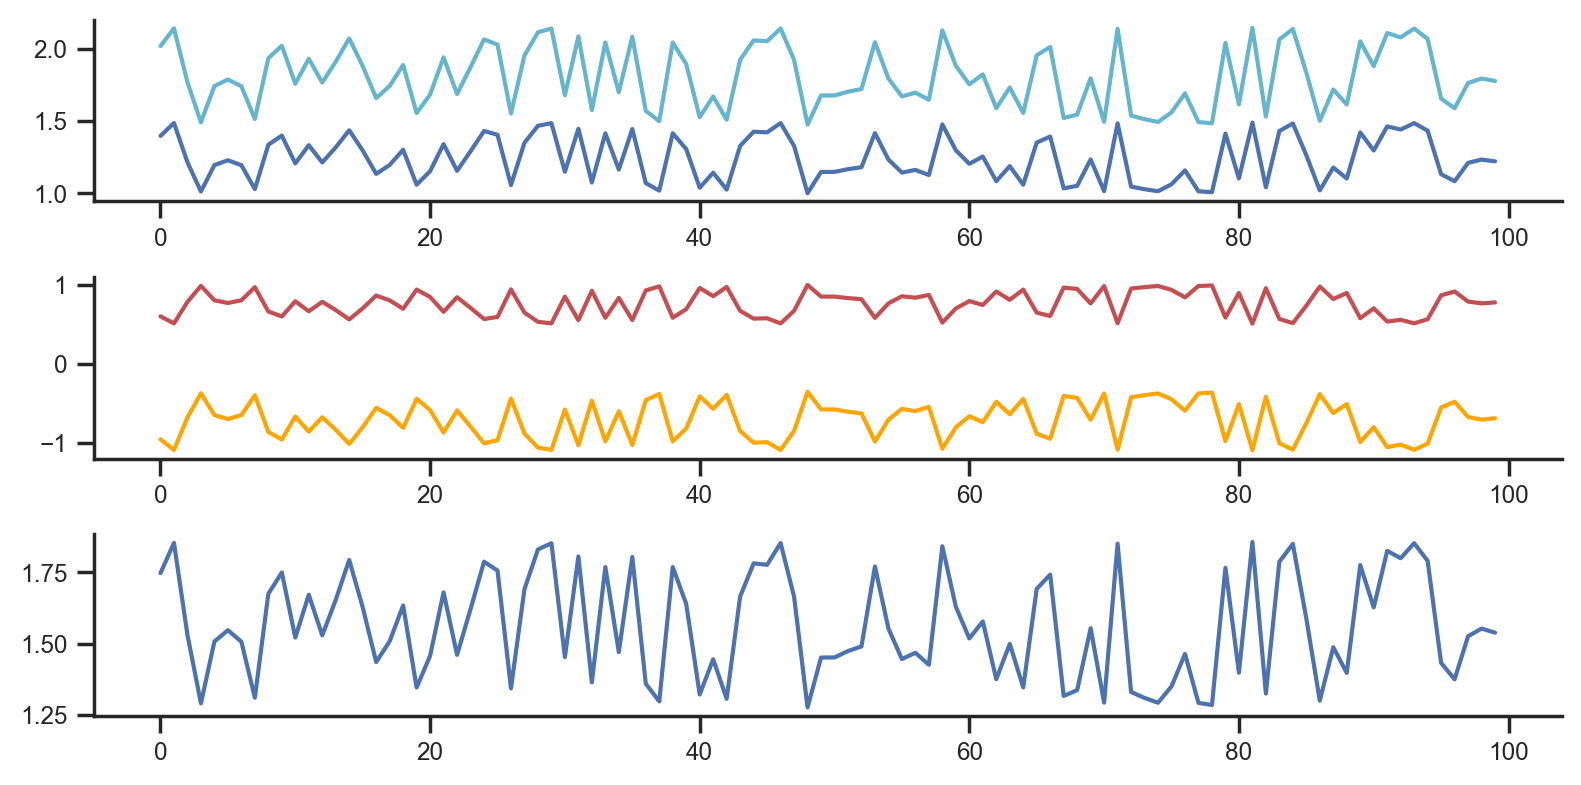

In [4]:
hh = H_init.detach().numpy()

f, ax = plt.subplots(3, 1, figsize=(8,4))
ax[0].plot(H[0, :], c='b', label='true 1')
ax[0].plot(hh[0, :], c='c', label='fit 1')
ax[1].plot(H[1, :], c='r', label='true 2')
ax[1].plot(hh[1, :], c='orange', label='fit 2')
ax[2].plot(h_init[0, :].detach().numpy(), c = 'b', label='init')
plt.tight_layout()
plt.show()

In [5]:
print('h_coeff: ',h_coeff)
print('h_bias: ',h_bias)

h_coeff:  tensor([1.1559, 1.2741], requires_grad=True)
h_bias:  tensor([1.0000e-04, 1.0000e-04], requires_grad=True)
